<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-human.tgz
!tar zxvf *-images.tgz
!tar zxvf *-human.tgz

In [2]:
import re
import os.path
import numpy as np
from PIL import Image
import torch
from torch import nn, optim, float
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [3]:
root_dir = "./BSDS300"
train_data = os.path.join(root_dir, 'images/train')
test_data = os.path.join(root_dir, 'images/test')
labels = os.path.join(root_dir, 'human/color')
pixels = 321

In [4]:
def extract_labels(label_files):
    """Converts segmentation data from .seg files into np.array"""
    meta = {}
    data = []
    with open(label_files, 'r') as f:
        matcher = re.compile('(?P<seg>^[0-9 ]+)')
        for line in f:
            seg_match = matcher.search(line)
            if seg_match:
                string_segment = seg_match.group('seg').split(' ')
                int_segment = np.asarray(string_segment, dtype=int)
                data.append(int_segment)
                continue
            elif "data" not in line:
                meta_data = line.strip('\n').split(' ', 1)
                index, value = meta_data[0], meta_data[1]
                meta[index] = value
    height, width = int(meta['height']), int(meta['width'])
    seg_num = int(meta['segments'])
    # print(f"User id: {meta['user']}     Image id: {meta['image']}")
    # print(f"Height: {height}       Width: {width}")
    segmentation = np.zeros((height, width))
    for seg in data:
        segmentation[seg[1], seg[2]:(seg[3] + 1)] = seg[0]
    return segmentation, seg_num

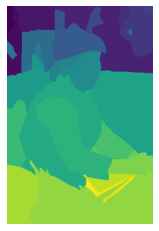

In [5]:
def create_image(seg_val, seg_max):
    """Creates an image using extracted segmentation data"""
    plt.figure()
    plt.axis('off')
    plt.imshow(seg_val)
    plt.show()

# To test whether extracting segmentations is successful
test = os.path.join(labels, '1105/15004.seg')
segmentation, seg_num = extract_labels(test)
create_image(segmentation, seg_num)

In [6]:
class CropArrayCentre(object):
    """Custom transform to crop the centre of arrays (both images and segmentations)"""
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["image"], sample["label"]
        y, x, _ = image.shape
        image = self.crop(image, x, y)
        label = self.crop(label, x, y)
        return {'image': image, 'label': label}

    def crop(self, sample, x, y):
        crop_y, crop_x = self.output_size
        start_x, start_y = x // 2 - (crop_x // 2), y // 2 - (crop_y // 2)
        return sample[start_y: start_y + crop_y, start_x: start_x + crop_x]


class TwoTensor(object):
    """Custom transform to convert arrays (both images and segmentations) to tensors"""

    def __call__(self, sample):
        image = torch.from_numpy(sample["image"]).permute(2, 0, 1).float()
        label = torch.from_numpy(sample["label"])
        return {'image': image, 'label': label}

In [7]:
class Berkeley(Dataset):
    """Custom dataset containing training/test data + their respective labels"""
    
    def __init__(self, image_files, label_files):
        """Images and labels are converted into np.arrays and listed in ascending index
        :param image_files: Path to images
        :param label_files: Path to segmentation labels"""
        self.images, self.labels = self.array_from_path(image_files, label_files)
        self.transform = transforms.Compose([
            CropArrayCentre(pixels),  # Crops image + segmentation to uniform size
            TwoTensor()  # Converts image + segmentation np.array to torch.tensor
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        sample = {"image": self.images[index], "label": self.labels[index]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def array_from_path(self, image_files, label_files):
        images = sorted([img for img in os.listdir(image_files)][0:20])  # List in format .jpg
        image_names = [os.path.splitext(img)[0] for img in images]  # List of image ids (sans .jpg)
        ordered_files = {}
        for root, user_folder, files in os.walk(label_files):
            for file in files:
                file_name = os.path.splitext(file)[0]
                if file_name in image_names:
                    file_path = os.path.join(root, file)
                    seg, _ = extract_labels(file_path)
                    ordered_files[file_name] = seg

        images = [np.asarray(Image.open(os.path.join(image_files, img))) for img in images]
        labels = [value for _, value in sorted(ordered_files.items(), key=lambda ele: ele[0])]
        return images, labels

In [8]:
train_loader = DataLoader(Berkeley(train_data, labels), batch_size=5)
test_loader = DataLoader(Berkeley(test_data, labels), batch_size=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


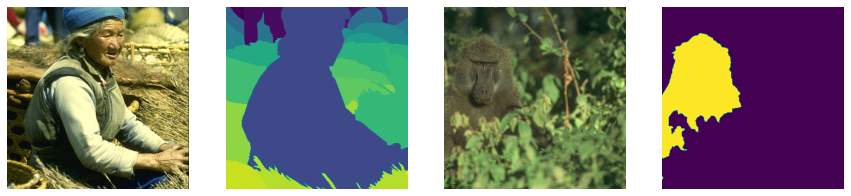

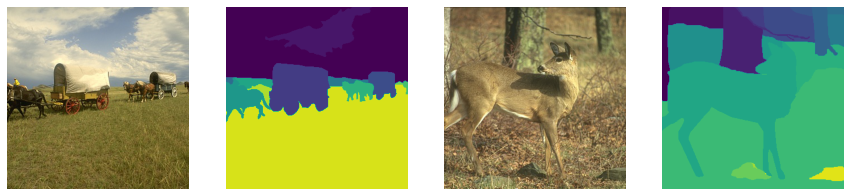

In [9]:
def show_images(sample_batched, i):
    """Show images and segmentation side-by-side in a batch of samples"""
    images_batch, labels_batch = sample_batched['image'], sample_batched['label']
    image_0, seg_0 = (images_batch[i].permute(1, 2, 0)), (labels_batch[i])
    image_1, seg_1 = (images_batch[i+1].permute(1, 2, 0)), (labels_batch[i+1])
    show = [image_0 / 255, seg_0, image_1 / 255, seg_1]
    
    for ind in range(len(show)):
      axarr[ind].imshow(show[ind])
      axarr[ind].axis('off')

for i_batch, sample_batched in enumerate(train_loader):
    if i_batch == 1: # Stop and examine a specific batch
      for ind in range(0,4,2):
        f, axarr = plt.subplots(1,4, figsize=(15,15)) 
        show_images(sample_batched, ind)
        plt.ioff()
        plt.show()
      break

In [10]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Using {device} device')

Using cuda device


In [11]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, (3, 3)),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stack(x)
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self, channels, final_output=1):
        super(UNet, self).__init__()
        self.down, self.up = channels, [c for c in reversed(channels[1:])]  # Number of feature channels
        self.down_layers, self.up_layers = nn.ModuleList(), nn.ModuleList()
        self.build_layers(final_output)  # Generate list of required modules
        self.features = []

    def forward(self, x, output_size=False):
        output = self.expansive(self.contracting(x))
        if output_size:
            assert isinstance(output_size, (int, tuple))
            if isinstance(output_size, int):
                output_size = (output_size, output_size)
            else:
                assert len(output_size) == 2
                output_size = output_size
            output = F.interpolate(output, output_size)
        return output

    def build_layers(self, final):
        # Generate sequence layer for the expansive & contracting path
        for i in range(len(self.down) - 1):
            self.down_layers.append(Block(self.down[i], self.down[i + 1]))
            if i != max(range(len(self.down) - 1)):
                self.down_layers.append(nn.MaxPool2d((2, 2), stride=2))  # 2x2 max pooling
                self.up_layers.append(nn.ConvTranspose2d(self.up[i], self.up[i + 1], (2, 2), stride=2))
                self.up_layers.append(Block(self.up[i], self.up[i + 1]))
            else:
                self.up_layers.append(nn.Conv2d(self.up[-1], final, (1, 1)))  # 1x1 convolutional layer

    def contracting(self, model):
        """3x3 convolutions & ReLU followed by 2x2 max pooling for downsampling"""
        for i in range(0, len(self.down_layers) - 1, 2):
            block = self.down_layers[i](model)
            self.features.append(block)  # Store block outputs for concatenation
            model = self.down_layers[i + 1](block)
        model = self.down_layers[-1](model)
        return model

    def expansive(self, model):
        """Upsampling followed by 3x3 convolutions & ReLU"""
        for i in range(0, len(self.up_layers) - 1, 2):
            block = self.up_layers[i](model)
            feature = self.crop(self.features[::-1][int(i / 2)], block)
            block = torch.cat([block, feature], dim=1)  # Double the number of feature channels
            model = self.up_layers[i + 1](block)
        model = self.up_layers[-1](model)
        return model

    def crop(self, feature, block):  # Necessary due to loss of border pixels every convolution
        _, _, h, w = block.shape
        feature = transforms.CenterCrop([h, w])(feature)
        return feature

In [13]:
x = torch.randn(1, 1, 572, 572)
channels = [1, 64, 128, 256, 512, 1024]
handler = UNet(channels)
x = handler(x)
x.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 388, 388])

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Compare predictions and targets in mini-batches"""
    size = len(dataloader.dataset)
    for batch, sample_batched in enumerate(dataloader):
        images_batch, labels_batch = sample_batched['image'].to(device), sample_batched['label'].to(device)
        pred = nn.Softmax(dim=1)(model(images_batch, pixels))
        loss = loss_fn(pred, labels_batch.long())

        # Backpropagation to adjust the weights and biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(images_batch)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test_loop(dataloader, model, loss_fn):
    "Test the model with previously unseen, new images"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample in dataloader:
            images, labels = sample['image'].to(device), sample['label'].to(device)
            pred = nn.Softmax(dim=1)(model(images, pixels))
            test_loss += loss_fn(pred, labels.long()).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= (size * pixels * pixels)  # Fraction of correctly classified pixels
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
channels = [3, 64, 128, 256, 512, 1024]
handler = UNet(channels, 113).to(device)  # 113 unique classes
loss_fn = nn.CrossEntropyLoss()  # Loss function for multi-class
optimiser = optim.SGD(handler.parameters(), lr=1e-3)
epochs = 5

In [17]:
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_loader, handler, loss_fn, optimiser)
    test_loop(test_loader, handler, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.727844  [    5/   20]
loss: 4.726760  [   10/   20]
loss: 4.726086  [   15/   20]
loss: 4.727397  [   20/   20]
Test Error: 
 Accuracy: 0.6%, Avg loss: 4.726593 

Epoch 2
-------------------------------
loss: 4.727843  [    5/   20]
loss: 4.726758  [   10/   20]
loss: 4.726081  [   15/   20]
loss: 4.727395  [   20/   20]
Test Error: 
 Accuracy: 0.6%, Avg loss: 4.726592 

Epoch 3
-------------------------------
loss: 4.727842  [    5/   20]
loss: 4.726758  [   10/   20]
loss: 4.726076  [   15/   20]
loss: 4.727392  [   20/   20]
Test Error: 
 Accuracy: 0.6%, Avg loss: 4.726591 

Epoch 4
-------------------------------
loss: 4.727840  [    5/   20]
loss: 4.726756  [   10/   20]
loss: 4.726071  [   15/   20]
loss: 4.727390  [   20/   20]
Test Error: 
 Accuracy: 0.6%, Avg loss: 4.726589 

Epoch 5
-------------------------------
loss: 4.727839  [    5/   20]
loss: 4.726754  [   10/   20]
loss: 4.726066  [   15/   20]
loss: 4.727387  [   20/   